In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from google.colab import drive
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, log_loss
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = load_dataset('csv', data_files="/content/drive/MyDrive/News_dataset.csv")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    fpr_specificity = 1 - specificity

    logloss = log_loss(y_true, y_pred)

    beta = 2
    f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

    mcc = (cm[0, 0] * cm[1, 1] - cm[0, 1] * cm[1, 0]) / np.sqrt((cm[0, 0] + cm[0, 1]) * (cm[0, 0] + cm[1, 0]) * (cm[1, 1] + cm[0, 1]) * (cm[1, 1] + cm[1, 0]))

    gmean = np.sqrt(recall * specificity)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'fpr': fpr_specificity,
        'log_loss': logloss,
        'f2_score': f2_score,
        'mcc': mcc,
        'gmean': gmean,
        'confusion_matrix': cm,
        'roc_auc': roc_auc
    }

In [ ]:
dataset = dataset['train'].map(lambda x: {'title': x['title'], 'label': x['label']})

train_dataset = dataset.train_test_split(test_size=0.2)['train']
test_dataset = dataset.train_test_split(test_size=0.2)['test']

def tokenize_data(example):
    title = example['title']
    if title is None:
        return {'input_ids': [], 'attention_mask': []}
    encoded = tokenizer(title, truncation=True, padding='max_length')
    encoded = {key: value.tolist() if isinstance(value, np.ndarray) else value for key, value in encoded.items()}
    return encoded

train_dataset = train_dataset.filter(lambda example: example['title'] is not None)
test_dataset = test_dataset.filter(lambda example: example['title'] is not None)

X_train = train_dataset['title']
y_train = train_dataset['label']

X_test = test_dataset['title']
y_test = test_dataset['label']

X_train_filtered = [title for title, label in zip(X_train, y_train) if title is not None]
y_train_filtered = [label for title, label in zip(X_train, y_train) if title is not None]
X_test_filtered = [title for title, label in zip(X_test, y_test) if title is not None]
y_test_filtered = [label for title, label in zip(X_test, y_test) if title is not None]


vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=5, max_df=0.8)
X_train_tfidf = vectorizer.fit_transform(X_train_filtered)
X_test_tfidf = vectorizer.transform(X_test_filtered)

logistic_regression = SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=42)
logistic_regression.fit(X_train_tfidf, y_train_filtered)

y_pred = logistic_regression.predict(X_test_tfidf)

Map:   0%|          | 0/20800 [00:00<?, ? examples/s]

Filter:   0%|          | 0/16640 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4160 [00:00<?, ? examples/s]

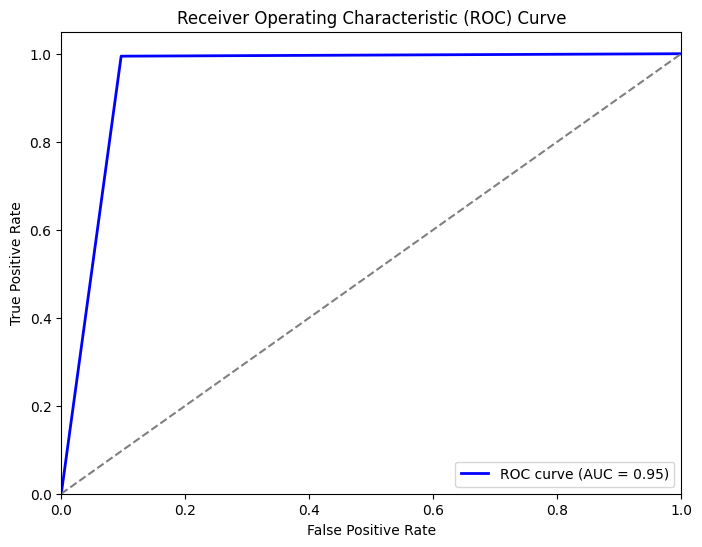

accuracy: 0.9478239366963402
precision: 0.9518741680042333
recall: 0.9478239366963402
f1: 0.9477690367175533
specificity: 0.9034282955094157
fpr: 0.09657170449058428
log_loss: 1.8806159409257468
f2_score: 0.9486312232073157
mcc: 0.8997486217094035
gmean: 0.9253599102903686
confusion_matrix: [[1871  200]
 [  11 1962]]
roc_auc: 0.9489265147085851


In [ ]:
metrics = compute_metrics(y_test_filtered, y_pred)

for key, value in metrics.items():
    print(f'{key}: {value}')